<a href="https://colab.research.google.com/github/aishwarya8ts/DBMS-Travel-Tour/blob/main/pacman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys
print(sys.executable)

/usr/bin/python3


In [7]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
from collections import deque
import random
import time

In [8]:
class DQNNet(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(DQNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones
    def __len__(self):
        return len(self.buffer)

In [78]:
class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.obs_size = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.net = DQNNet(self.obs_size, self.n_actions)
        self.target_net = DQNNet(self.obs_size, self.n_actions)
        self.target_net.load_state_dict(self.net.state_dict())
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.sync_target_steps = 1000
        self.total_steps = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state_v = torch.tensor([state], dtype=torch.float32)
        q_vals = self.net(state_v)
        _, act_v = torch.max(q_vals, dim=1)
        return int(act_v.item())

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states_v = torch.tensor(states, dtype=torch.float32)
        next_states_v = torch.tensor(next_states, dtype=torch.float32)
        actions_v = torch.tensor(actions)
        rewards_v = torch.tensor(rewards, dtype=torch.float32)
        done_mask = torch.tensor(dones, dtype=torch.bool)

        q_vals = self.net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
        with torch.no_grad():
            next_q_vals = self.target_net(next_states_v).max(1)[0]
            next_q_vals[done_mask] = 0.0
            expected_q_vals = rewards_v + self.gamma * next_q_vals

        loss = nn.MSELoss()(q_vals, expected_q_vals)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.total_steps += 1
        if self.total_steps % self.sync_target_steps == 0:
            self.target_net.load_state_dict(self.net.state_dict())

    def train(self, episodes=500):
        scores = []
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.replay_buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.train_step()
            scores.append(total_reward)
            if ep % 10 == 0:
                print(f"Episode {ep}, Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return scores




In [19]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(ActorCriticNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU()
        )
        self.policy = nn.Linear(128, n_actions)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

In [79]:
class A3CAgent:
    def __init__(self, env):
        self.env = env
        self.obs_size = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.net = ActorCriticNet(self.obs_size, self.n_actions)
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        self.gamma = 0.99

    def select_action(self, state):
        state_v = torch.tensor([state], dtype=torch.float32)
        logits, _ = self.net(state_v)
        probs = torch.softmax(logits, dim=1)
        action = torch.multinomial(probs, 1).item()
        return action

    def train(self, episodes=100):
      rewards_history = []  # <-- Step 1: Initialize list

      for ep in range(episodes):
          state = self.env.reset()
          done = False
          log_probs = []
          values = []
          rewards = []

          while not done:
              state_v = torch.tensor([state], dtype=torch.float32)
              logits, value = self.net(state_v)
              probs = torch.softmax(logits, dim=1)
              action = torch.multinomial(probs, 1).item()

              log_prob = torch.log(probs[0, action])
              next_state, reward, terminated, truncated, _ = self.env.step(action)
              done = terminated or truncated

              log_probs.append(log_prob)
              values.append(value)
              rewards.append(reward)

              state = next_state

          # Compute returns and advantages
          returns = []
          R = 0
          for r in reversed(rewards):
              R = r + self.gamma * R
              returns.insert(0, R)
          returns = torch.tensor(returns)
          values = torch.cat(values).squeeze()
          log_probs = torch.stack(log_probs)

          advantage = returns - values

          # Loss calculation
          actor_loss = -(log_probs * advantage.detach()).mean()
          critic_loss = advantage.pow(2).mean()
          loss = actor_loss + critic_loss

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          total_reward = sum(rewards)
          rewards_history.append(total_reward)  # <-- Step 2: Save reward

          if ep % 10 == 0:
              print(f"A3C Episode {ep}, total reward: {total_reward}")

      return rewards_history  # <-- Step 3: Return the reward list





In [62]:
env = gym.make("CartPole-v1", new_step_api=True)

In [63]:
import random
from collections import deque
import numpy as np
import torch

In [64]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

In [65]:
print("Training DQN...")
dqn_agent = DQNAgent(env)
dqn_scores = dqn_agent.train(episodes=100)

Training DQN...
Episode 0, Reward: 49.0, Epsilon: 1.000


<ipython-input-18-f6057ea3e6bc>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_v = torch.tensor(states, dtype=torch.float32)
<ipython-input-18-f6057ea3e6bc>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states_v = torch.tensor(next_states, dtype=torch.float32)
<ipython-input-18-f6057ea3e6bc>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions_v = torch.tensor(actions)
<ipython-input-18-f6057ea3e6bc>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

Episode 10, Reward: 49.0, Epsilon: 0.096
Episode 20, Reward: 8.0, Epsilon: 0.010
Episode 30, Reward: 86.0, Epsilon: 0.010
Episode 40, Reward: 10.0, Epsilon: 0.010
Episode 50, Reward: 79.0, Epsilon: 0.010
Episode 60, Reward: 9.0, Epsilon: 0.010
Episode 70, Reward: 9.0, Epsilon: 0.010
Episode 80, Reward: 9.0, Epsilon: 0.010
Episode 90, Reward: 10.0, Epsilon: 0.010


In [66]:
print("Training A3C...")
a3c_agent = A3CAgent(env)
a3c_agent.train(episodes=100)

Training A3C...
A3C Episode 0, total reward: 26.0
A3C Episode 10, total reward: 61.0
A3C Episode 20, total reward: 45.0
A3C Episode 30, total reward: 14.0
A3C Episode 40, total reward: 14.0
A3C Episode 50, total reward: 45.0
A3C Episode 60, total reward: 11.0
A3C Episode 70, total reward: 17.0
A3C Episode 80, total reward: 38.0
A3C Episode 90, total reward: 68.0


[26.0,
 18.0,
 17.0,
 11.0,
 28.0,
 25.0,
 14.0,
 19.0,
 38.0,
 43.0,
 61.0,
 32.0,
 31.0,
 20.0,
 33.0,
 14.0,
 31.0,
 24.0,
 17.0,
 22.0,
 45.0,
 12.0,
 16.0,
 23.0,
 26.0,
 28.0,
 13.0,
 12.0,
 26.0,
 26.0,
 14.0,
 16.0,
 37.0,
 14.0,
 52.0,
 17.0,
 17.0,
 17.0,
 21.0,
 15.0,
 14.0,
 29.0,
 22.0,
 46.0,
 24.0,
 21.0,
 18.0,
 17.0,
 21.0,
 13.0,
 45.0,
 33.0,
 13.0,
 46.0,
 29.0,
 23.0,
 62.0,
 25.0,
 26.0,
 67.0,
 11.0,
 22.0,
 33.0,
 22.0,
 15.0,
 48.0,
 16.0,
 19.0,
 63.0,
 18.0,
 17.0,
 70.0,
 31.0,
 20.0,
 22.0,
 59.0,
 16.0,
 33.0,
 28.0,
 52.0,
 38.0,
 59.0,
 51.0,
 31.0,
 33.0,
 37.0,
 16.0,
 23.0,
 11.0,
 27.0,
 68.0,
 128.0,
 91.0,
 15.0,
 32.0,
 48.0,
 40.0,
 21.0,
 20.0,
 29.0]

In [67]:
import matplotlib.pyplot as plt

In [72]:
a3c_agent = A3CAgent(env)
a3c_scores = a3c_agent.train(episodes=100)

A3C Episode 0, total reward: 22.0
A3C Episode 10, total reward: 60.0
A3C Episode 20, total reward: 25.0
A3C Episode 30, total reward: 17.0
A3C Episode 40, total reward: 15.0
A3C Episode 50, total reward: 13.0
A3C Episode 60, total reward: 22.0
A3C Episode 70, total reward: 25.0
A3C Episode 80, total reward: 14.0
A3C Episode 90, total reward: 16.0


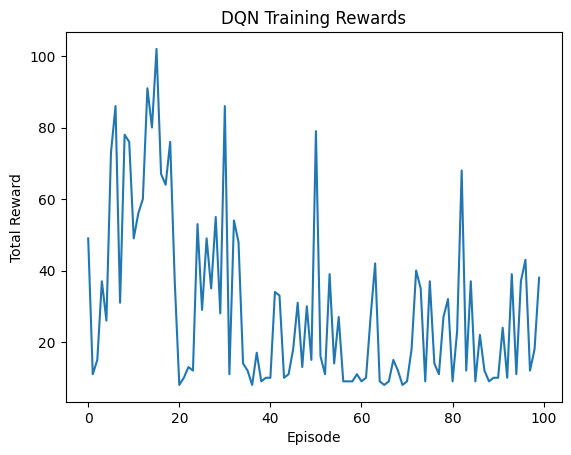

In [73]:
plt.plot(dqn_scores)
plt.title("DQN Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [74]:
torch.save(dqn_agent.net.state_dict(), "dqn_model.pth")
torch.save(a3c_agent.net.state_dict(), "a3c_model.pth")

In [75]:
dqn_agent.net.load_state_dict(torch.load("dqn_model.pth"))
a3c_agent.net.load_state_dict(torch.load("a3c_model.pth"))

<All keys matched successfully>

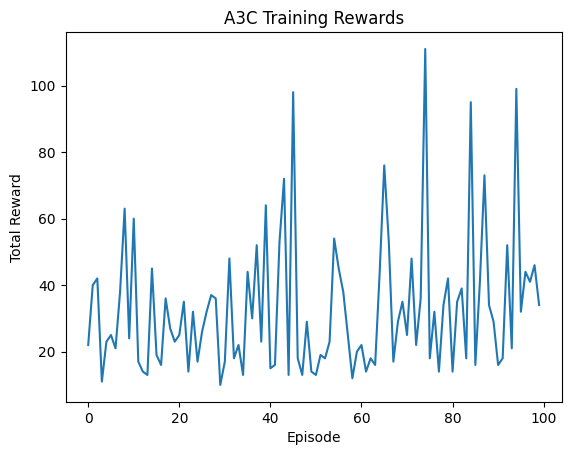

In [76]:
plt.plot(a3c_scores)
plt.title("A3C Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

Episode 0, Reward: 45.0, Epsilon: 1.000


<ipython-input-18-f6057ea3e6bc>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_v = torch.tensor(states, dtype=torch.float32)
<ipython-input-18-f6057ea3e6bc>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states_v = torch.tensor(next_states, dtype=torch.float32)
<ipython-input-18-f6057ea3e6bc>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions_v = torch.tensor(actions)
<ipython-input-18-f6057ea3e6bc>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

Episode 10, Reward: 44.0, Epsilon: 0.111
Episode 20, Reward: 39.0, Epsilon: 0.019
Episode 30, Reward: 38.0, Epsilon: 0.010
Episode 40, Reward: 23.0, Epsilon: 0.010
Episode 50, Reward: 26.0, Epsilon: 0.010
Episode 60, Reward: 30.0, Epsilon: 0.010
Episode 70, Reward: 20.0, Epsilon: 0.010
Episode 80, Reward: 13.0, Epsilon: 0.010
Episode 90, Reward: 10.0, Epsilon: 0.010
A3C Episode 0, total reward: 18.0
A3C Episode 10, total reward: 26.0
A3C Episode 20, total reward: 20.0
A3C Episode 30, total reward: 11.0
A3C Episode 40, total reward: 14.0
A3C Episode 50, total reward: 34.0
A3C Episode 60, total reward: 32.0
A3C Episode 70, total reward: 15.0
A3C Episode 80, total reward: 19.0
A3C Episode 90, total reward: 39.0


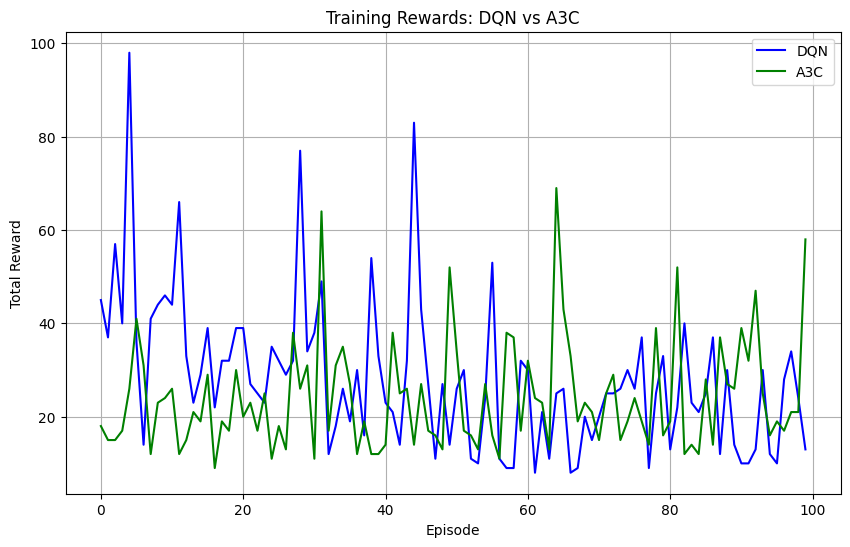

In [77]:
dqn_agent = DQNAgent(env)
dqn_scores = dqn_agent.train(episodes=100)

a3c_agent = A3CAgent(env)
a3c_scores = a3c_agent.train(episodes=100)

# Plot both reward curves
plt.figure(figsize=(10, 6))
plt.plot(dqn_scores, label='DQN', color='blue')
plt.plot(a3c_scores, label='A3C', color='green')
plt.title("Training Rewards: DQN vs A3C")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()